# EDA for the *Child Mind Institute — Problematic Internet Use* competition

This notebook demonstrates:

- An initial analysis of the dataset.
- Why regression models outperform classification models.
- How to optimise thresholds to round regression outputs effectively.

In [87]:
#import necessary libraries
import polars as pl
import polars.selectors as cs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import numpy as np
import seaborn as sns
import lightgbm
from colorama import Fore, Style
from scipy.optimize import minimize

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay

target_labels = ['None', 'Mild', 'Moderate', 'Severe']

# 1. Overview

In [3]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train.shape

(3960, 82)

=> The training dataset has 3960 samples (children who participate in the study) and 80 features (not counting the `id` column and the target `sii`).

## Missing values

All columns have a substantial proportion of missing values, except `id` and the three basic demographic columns for sex, age and season of enrollment. Even the target `sii` has missing values:

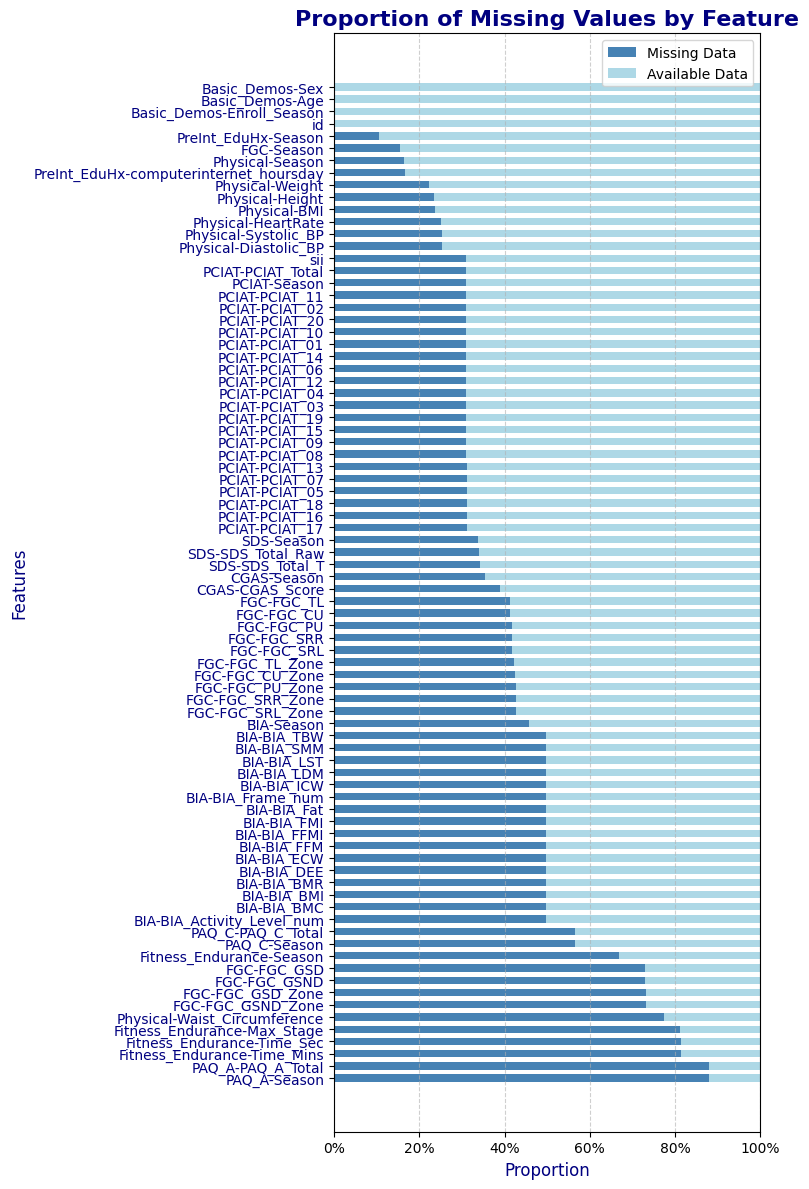

In [8]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)

plt.figure(figsize=(8, 12))
plt.title('Proportion of Missing Values by Feature', fontsize=16, fontweight='bold', color='navy')

null_ratios = missing_count.get_column('null_ratio')
available_ratios = 1 - null_ratios
features = missing_count.get_column('feature')

bar_width = 0.6
y_positions = np.arange(len(features))

plt.barh(
    y_positions, 
    null_ratios, 
    color='steelblue', 
    height=bar_width, 
    label='Missing Data'
)

plt.barh(
    y_positions, 
    available_ratios, 
    left=null_ratios, 
    color='lightblue',  
    height=bar_width, 
    label='Available Data'
)


plt.yticks(
    y_positions, 
    features, 
    fontsize=10, 
    color='navy'
)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)

plt.xlabel('Proportion', fontsize=12, color='navy')
plt.ylabel('Features', fontsize=12, color='navy')
plt.legend(fontsize=10, loc='upper right')

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Now only consider the data in the dataset part with non-null ```sii```, the following chart:

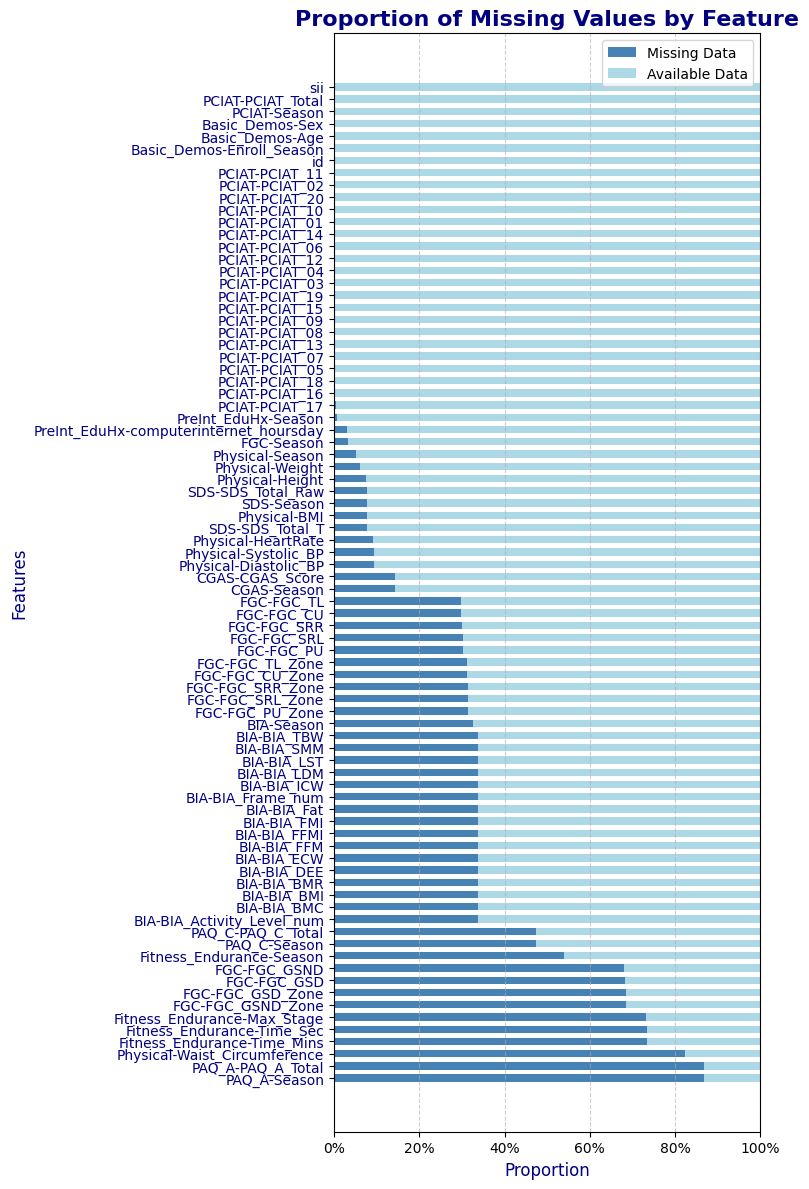

In [10]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)

plt.figure(figsize=(8, 12))
plt.title('Proportion of Missing Values by Feature', fontsize=16, fontweight='bold', color='navy')

null_ratios = missing_count.get_column('null_ratio')
available_ratios = 1 - null_ratios
features = missing_count.get_column('feature')

bar_width = 0.6
y_positions = np.arange(len(features))

plt.barh(
    y_positions, 
    null_ratios, 
    color='steelblue', 
    height=bar_width, 
    label='Missing Data'
)

plt.barh(
    y_positions, 
    available_ratios, 
    left=null_ratios, 
    color='lightblue',  
    height=bar_width, 
    label='Available Data'
)


plt.yticks(
    y_positions, 
    features, 
    fontsize=10, 
    color='navy'
)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)

plt.xlabel('Proportion', fontsize=12, color='navy')
plt.ylabel('Features', fontsize=12, color='navy')
plt.legend(fontsize=10, loc='upper right')

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## The target

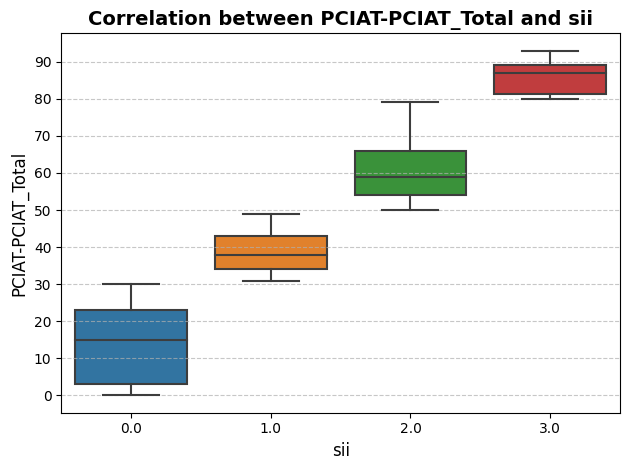

In [17]:
train_pd = train.to_pandas()
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=train_pd)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Correlation between PCIAT-PCIAT_Total and sii', fontsize=14, fontweight='bold')
plt.xlabel('sii', fontsize=12)
plt.ylabel('PCIAT-PCIAT_Total', fontsize=12)
y_ticks = np.arange(train['PCIAT-PCIAT_Total'].min(), train['PCIAT-PCIAT_Total'].max(), 10)
plt.yticks(y_ticks)
plt.tight_layout()
plt.show()

The target ```sii``` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score. That's why PCIAT results don't exist in test data.

- 0-30 Normal (0)
- 31-49 Mild (1)
- 50-79 Moderate (2)
- 80-100 Severe (3)
  
=>Proof: https://digitalwellnesslab.org/wp-content/uploads/Scoring-Overview.pdf

**Conclusion:**
1. We focus on predicting the target from all other features except the PCIAT results.
2. We know the target only for two thirds of the samples. Therefore we use it to train supervised learning model.
3. There are 2 approaches: directly predict `sii` or predict `PCIAT-PCIAT_Total` and then transform this prediction to a `sii` prediction for submission.

In [6]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


## Demographics

The study participants are between 5 and 22 years old. There are twice as many boys as girls.

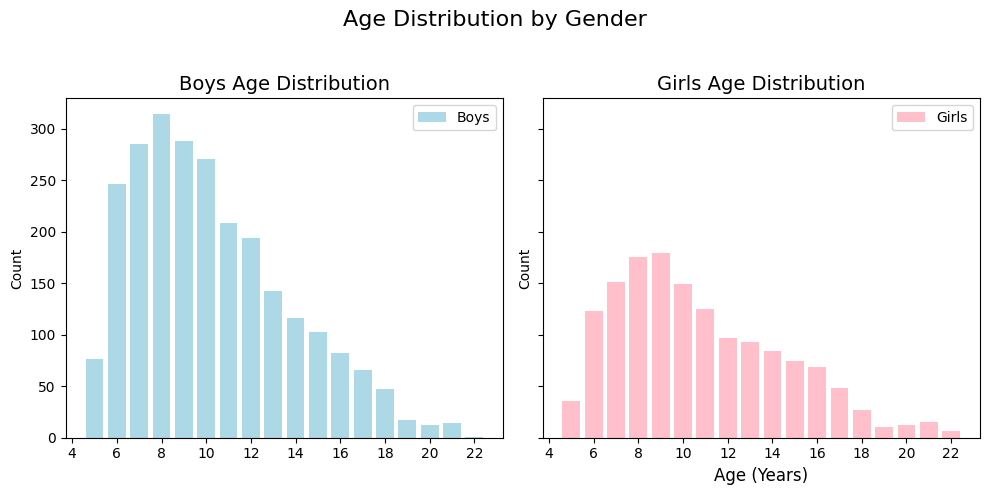

In [28]:
_, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for sex in range(2):
    ax = axs[sex]
    # Filter data by gender and count the occurrences of each age
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'pink'][sex],
           label=['Boys', 'Girls'][sex])
    
    ax.set_ylabel('Count')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'{["Boys", "Girls"][sex]} Age Distribution', fontsize=14)
    ax.legend()

plt.suptitle('Age Distribution by Gender', fontsize=16)

axs[1].set_xlabel('Age (Years)', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


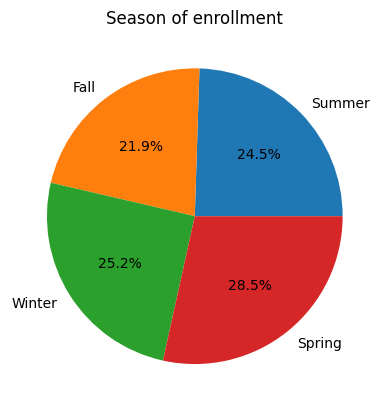

In [37]:
# The four seasons of enrollment have similar frequencies:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'),  autopct='%1.1f%%')
plt.title('Season of enrollment')
plt.show()

Boys have a slightly higher risk of internet addiction than girls:

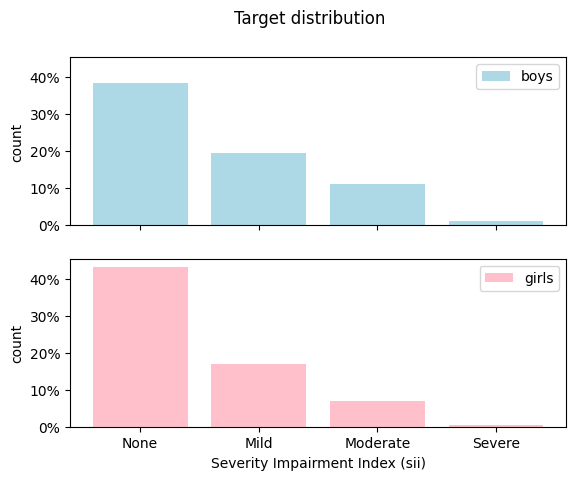

In [38]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'pink'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

# Actigraphy files (time series)

> [Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. A small actigraph unit, also called an actimetry sensor, is worn for a week or more to measure gross motor activity. The unit is usually in a wristwatch-like package worn on the wrist. The movements the actigraph unit undergoes are continually recorded and some units also measure light exposure. (Wikipedia)

We have actigraphy files for a quarter of the participants (996 to be precise). The file name is always `part-0.parquet`. 

Looking at the file of participant `id=0417c91e`, a six-year old right-handed girl, we see that this participant started to use the accelerometer on a Tuesday (weekday=2) of the second quarter of the year at second 44100 of the day (12:15 PM), 5 days after the PCIAT test. She gave the accelerometer back on the 53rd day after the PCIAT test, a Monday of the third quarter, at 9:08 AM.

The competition data page says that `time_of_day` is in format `%H:%M:%S.%9f`. This is obviously not true. `time_of_day` is measured in nanoseconds since midnight.

In [46]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy.head()

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0


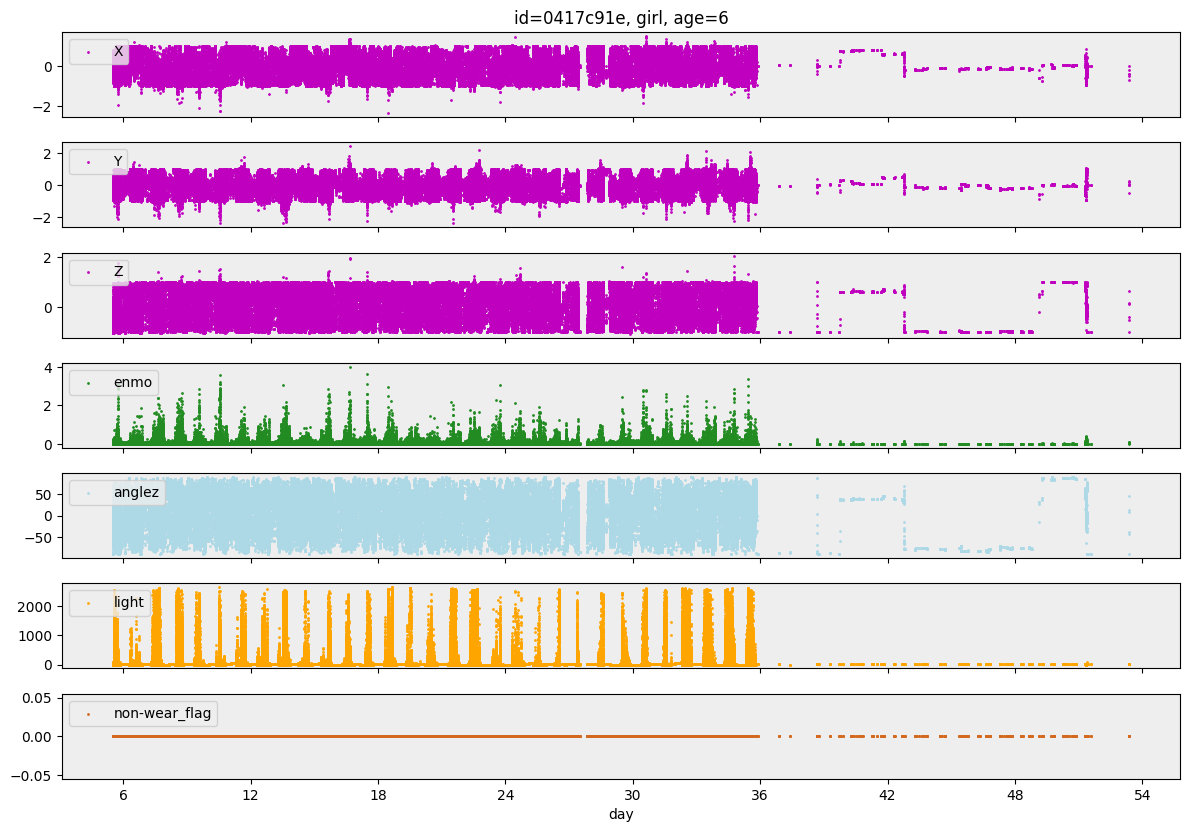

In [45]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

We can plot diagrams of the time series in this file. We can see:
1. We clearly see a daily pattern.
2. We see that the girl wore the accelerometer for 31 days and then took it off.
3. The dataset has a non-wear_flag column, but that flag is always zero for this participant. 
4. The girl is in an environment where the illuminance exceeds 2500 [lux](https://en.wikipedia.org/wiki/Lux) every day (the device cannot measure more than 2500 lux). Such a high illuminance means that she is outdoors or in a room with huge windows.
5. The girl moves a lot: she has enmo values above 2 almost every day.
6. The time series usually contain measurements every 5 seconds, but some time steps are missing. It is not documented under what conditions time steps are skipped.

**Conclusion:** 
- Some colummns are not really useful.
- The ENMO and light columns offer themselves for analysis with a one-dimensional convolutional neural network, but if we want to start simple, we can use some basic aggregations (mean, variance, ...) of the time series as features for a gradient-boosting model.


# 3. Classification model vs Regression model

We build basic classification and regression model  based on training dataframe to first test. We don't use the accelerometer data for this simple models.

Kappa score are used for evaluation. 
And the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) helps understand the output of the model.

> Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class \[...\]. The diagonal of the matrix therefore represents all instances that are correctly predicted. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another). (Wikipedia)

In [93]:
# Classification
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof = np.zeros(len(y), dtype=int)

for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = lightgbm.LGBMClassifier(verbose=-1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred
    
score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (classification with LightGBM){Style.RESET_ALL}")


# Fold 0: score=0.354
# Fold 1: score=0.350
# Fold 2: score=0.256
# Fold 3: score=0.317
# Fold 4: score=0.379
# Overall: score=0.331 (classification with LightGBM)


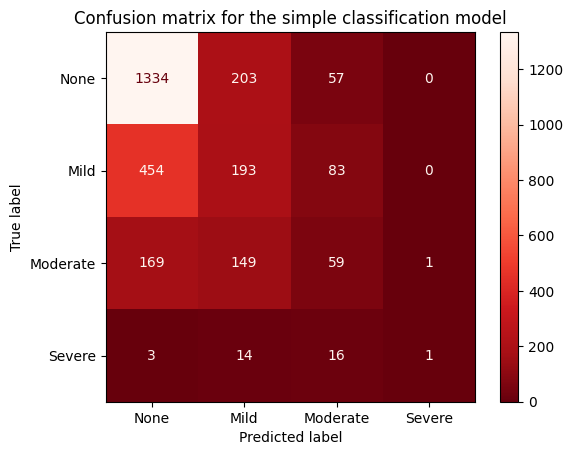

In [94]:
ConfusionMatrixDisplay.from_predictions(y, oof, cmap='Reds_r')  
plt.title('Confusion matrix for the simple classification model')
plt.xticks(np.arange(4), target_labels)
plt.yticks(np.arange(4), target_labels)
plt.show()

In [96]:
#Regression
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof_raw = np.zeros(len(y), dtype=float) # oof predictions, before rounding
oof = np.zeros(len(y), dtype=int) # oof predictions, rounded
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]

    model = lightgbm.LGBMRegressor(verbose=-1)
    model.fit(X_tr, y_tr.to_numpy())
    y_pred = model.predict(X_va)
    oof_raw[idx_va] = y_pred
    y_pred = y_pred.round(0).astype(int)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred

score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (regression with LightGBM){Style.RESET_ALL}")


# Fold 0: score=0.360
# Fold 1: score=0.422
# Fold 2: score=0.355
# Fold 3: score=0.384
# Fold 4: score=0.426
# Overall: score=0.389 (regression with LightGBM)


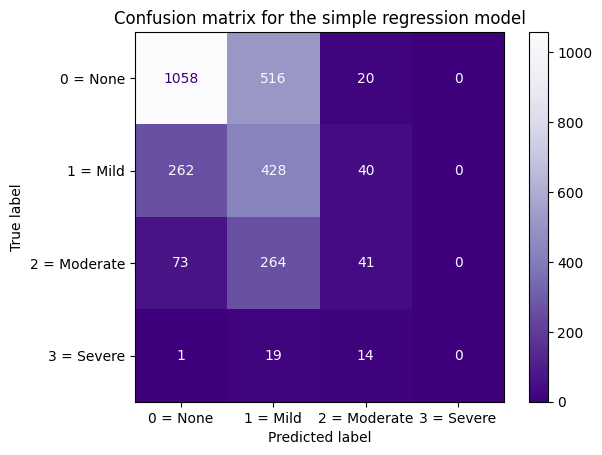

In [97]:
regression_labels = [f"{i} = {target_labels[i]}" for i in range(4)]

ConfusionMatrixDisplay.from_predictions(y, oof, cmap='Purples_r')
plt.title('Confusion matrix for the simple regression model')
plt.xticks(np.arange(4), regression_labels)
plt.yticks(np.arange(4), regression_labels)
plt.show()

The confusion matrix shows that our regression model never predicts the class 'Severe' (the rightmost column of the matrix is zero):

# Tuning the thresholds

Our regression model predicts float values, and in the previous section of this notebook, we rounded these float values to integers because the Kaggle competition expects integer predictions.

Use the thresholds of 0.5, 1.5, and 2.5 is not necessarily the best approach for achieving the highest score. We could use different thresholds, like 1, 2, and 3, but in practice, the thresholds of 0.5, 1.5, and 2.5 actually yield a significantly higher score.


In [105]:
def round_with_thresholds(raw_preds, thresholds):
    return np.where(raw_preds < thresholds[0], 0,
                    np.where(raw_preds < thresholds[1], 1,
                             np.where(raw_preds < thresholds[2], 2, 3)))


thresholds_1 = [1, 2, 3]
thresholds_2 = [0.5, 1.5, 2.5]

oof_rounded_1 = round_with_thresholds(oof_raw, thresholds_1)
score_1 = cohen_kappa_score(y, oof_rounded_1, weights='quadratic')

oof_rounded_2 = round_with_thresholds(oof_raw, thresholds_2)
score_2 = cohen_kappa_score(y, oof_rounded_2, weights='quadratic')


print(f"# Score with thresholds [1, 2, 3]: {score_1:.3f}")
print(f"# Score with thresholds [0.5, 1.5, 2.5]: {score_2:.3f}")

# Score with thresholds [1, 2, 3]: 0.254
# Score with thresholds [0.5, 1.5, 2.5]: 0.389


Reference: https://www.kaggle.com/code/ambrosm/piu-eda-which-makes-sense#A-simple-classification-model